# Data Engineering Test - Solvex 2023

Candidate: Heansell Diosymar Tahay Menchú

In [1]:
import os
import requests
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from bs4 import BeautifulSoup

## Global utils

In [2]:
## directory variables
covid_directory  = 'covid_files/'
flight_directory = 'flight_files/T_ONTIME_REPORTING.csv'
movie_directory  = 'movie_rating/'
url_bitcoin      = 'https://coinmarketcap.com/currencies/bitcoin/'

In [3]:
## Helper functions

def get_file_path(directory):
    """
    Listing all files within the directory.. 

    Parameters
    ----------

    directory : string
                The directory path where the target files are located.

    Return
    ------

    file_paths : list
                A list containing all the file paths mapped from the director. 
    """

    file_paths = []

    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)

        if os.path.isfile(file_path) and file_name.endswith('.csv'):
            file_paths.append(file_path)

    return file_paths

## Exercise 1 - Pandas Assessment

In [4]:
covid_files = get_file_path(covid_directory)
print(f"Number of covid files listed: {len(covid_files)}")

Number of covid files listed: 1143


In [5]:
## Merge all the files into a dataframe

dataframes = []

for file in covid_files:
    date = os.path.splitext(os.path.basename(file))[0]
    date = pd.to_datetime(date, format='%m-%d-%Y')


    df         = pd.read_csv(file, delimiter=',', encoding='utf-8')
    df['date'] = date

    dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)

In [6]:
## Get the shape of the dataframe
df.shape

(4287473, 22)

In [7]:
## Print the columns
df.columns

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incident_Rate', 'Case_Fatality_Ratio', 'date',
       'Province/State', 'Country/Region', 'Last Update', 'Incidence_Rate',
       'Case-Fatality_Ratio', 'Latitude', 'Longitude'],
      dtype='object')

#### Task: 'Calcula el promedio de casos confirmados por día en un país específico.'

In [8]:
## EDA of China
df_china = df[df['Country_Region'] == 'China'].copy()

In [9]:
df_china.shape

(36822, 22)

In [10]:
df_china.head(10)

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,...,Incident_Rate,Case_Fatality_Ratio,date,Province/State,Country/Region,Last Update,Incidence_Rate,Case-Fatality_Ratio,Latitude,Longitude
111,NaN,NaN,Anhui,China,2022-01-22 04:21:13,31.8257,117.2264,1009.0,6.0,NaN,...,1.595509,0.594648,2022-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,NaN,NaN,Beijing,China,2022-01-22 04:21:13,40.1824,116.4142,1258.0,9.0,NaN,...,5.840297,0.715421,2022-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,NaN,NaN,Chongqing,China,2022-01-22 04:21:13,30.0572,107.8740,611.0,6.0,NaN,...,1.969697,0.981997,2022-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,Fujian,China,2022-01-22 04:21:13,26.0789,117.9874,1450.0,1.0,NaN,...,3.679269,0.068966,2022-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,NaN,NaN,Gansu,China,2022-01-22 04:21:13,35.7518,104.2861,356.0,2.0,NaN,...,1.350019,0.561798,2022-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,NaN,NaN,Guangdong,China,2022-01-22 04:21:13,23.3417,113.4244,3710.0,8.0,NaN,...,3.269875,0.215633,2022-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,NaN,NaN,Guangxi,China,2022-01-22 04:21:13,23.8298,108.7881,693.0,2.0,NaN,...,1.406821,0.288600,2022-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,NaN,NaN,Guizhou,China,2022-01-22 04:21:13,26.8154,106.8748,160.0,2.0,NaN,...,0.444444,1.250000,2022-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,NaN,NaN,Hainan,China,2022-01-22 04:21:13,19.1959,109.7453,190.0,6.0,NaN,...,2.034261,3.157895,2022-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,NaN,NaN,Hebei,China,2022-01-22 04:21:13,37.8957,114.9042,1458.0,7.0,NaN,...,1.929592,0.480110,2022-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
## Get the average of confirmed cases by day (date)
confirmed_mean = df_china.groupby(['date'])['Confirmed'].agg(['mean'])

In [12]:
## Print the 10 first ascending
confirmed_mean.sort_values(by='mean', ascending=True).head(10)

,mean
date,
2020-03-22,2394.029412
2020-03-23,2396.794118
2020-03-24,2399.617647
2020-03-25,2401.705882
2020-03-26,2405.323529
2020-03-27,2408.000000
2020-03-28,2410.705882
2020-03-29,2413.470588
2020-03-30,2415.852941


<Figure size 1000x600 with 0 Axes>

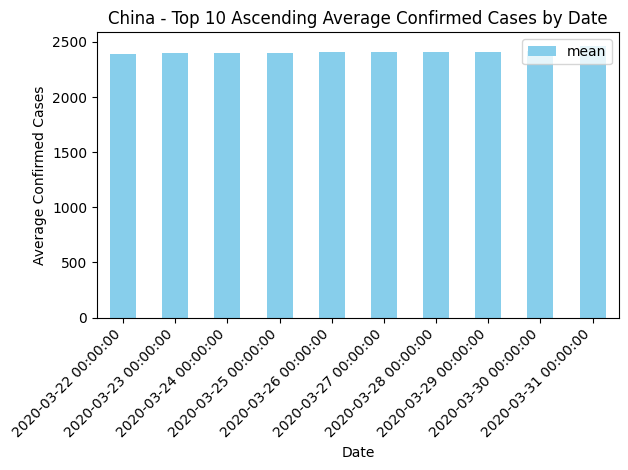

In [13]:
plt.figure(figsize=(10, 6))
confirmed_mean.sort_values(by='mean', ascending=True).head(10).plot(kind='bar', color='skyblue')
plt.title('China - Top 10 Ascending Average Confirmed Cases by Date')
plt.xlabel('Date')
plt.ylabel('Average Confirmed Cases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Task: 'Encuentra los 10 países con la tasa de mortalidad más alta hasta la fecha.'

In [14]:
## Clean up the 'Confirmed' and 'Deaths' columns

df[['Confirmed', 'Deaths']].isna().sum()

Confirmed     28
Deaths       433
dtype: int64

In [15]:
df[['Confirmed', 'Deaths']] = df[['Confirmed', 'Deaths']].fillna(0)

In [16]:
df[['Confirmed', 'Deaths']].isna().sum()

Confirmed    0
Deaths       0
dtype: int64

In [17]:
df_mortality = df.groupby(['Country_Region'])[['Confirmed', 'Deaths']].agg(['sum']).copy()

In [18]:
df_mortality['Mortality_Rate'] = (df_mortality['Deaths'] / df_mortality['Confirmed']) * 100

In [19]:
## Filter the countries where the mortality rate is greater than 0.5
## This filter is in order to discard the mortality rate outliers.

df_mortality[df_mortality['Mortality_Rate'] <= 0.5 * 100]\
    ['Mortality_Rate'].sort_values(ascending=False).head(10)

Country_Region
MS Zaandam                22.203828
Yemen                     19.232927
Sudan                      7.408319
Peru                       6.831597
Mexico                     6.112509
Syria                      5.858410
Egypt                      5.155101
Somalia                    5.025285
Ecuador                    4.526547
Bosnia and Herzegovina     4.179206
Name: Mortality_Rate, dtype: float64

## Exercise 2 - Spark Assessment

In [41]:
spark = SparkSession.builder.appName('FlightAnalyze').getOrCreate()

23/11/08 23:37:12 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [42]:
flight_schema = StructType([\
        StructField('YEAR', IntegerType(), True), \
        StructField('MONTH', IntegerType(), True), \
        StructField('DAY_OF_MONTH', IntegerType(), True), \
        StructField('FL_DATE', StringType(), True), \
        StructField('OP_UNIQUE_CARRIER', StringType(), True), \
        StructField('ORIGIN_AIRPORT_ID', IntegerType(), True), \
        StructField('ORIGIN_AIRPORT_SEQ_ID', IntegerType(), True), \
        StructField('ORIGIN_CITY_MARKET_ID', IntegerType(), True), \
        StructField('ORIGIN', StringType(), True), \
        StructField('ORIGIN_CITY_NAME', StringType(), True), \
        StructField('DEST_AIRPORT_ID', IntegerType(), True), \
        StructField('DEST_AIRPORT_SEQ_ID', IntegerType(), True), \
        StructField('DEST_CITY_MARKET_ID', IntegerType(), True), \
        StructField('DEST', StringType(), True), \
        StructField('DEST_CITY_NAME', StringType(), True), \
        StructField('DEP_DELAY', DoubleType(), True), \
        StructField('DEP_DELAY_NEW', DoubleType(), True), \
        StructField('DEP_DEL15', DoubleType(), True), \
        StructField('DEP_DELAY_GROUP', IntegerType(), True),\
        StructField('ARR_TIME', IntegerType(), True), \
        StructField('ARR_DELAY', DoubleType(), True), \
        StructField('ARR_DELAY_NEW', DoubleType(), True), \
        StructField('ARR_DEL15', DoubleType(), True), \
        StructField('ARR_DELAY_GROUP', IntegerType(), True), \
        StructField('CANCELLED', DoubleType(), True), \
        StructField('CARRIER_DELAY', DoubleType(), True), \
        StructField('WEATHER_DELAY', DoubleType(), True), \
        StructField('NAS_DELAY', DoubleType(), True), \
        StructField('SECURITY_DELAY', DoubleType(), True), \
        StructField('LATE_AIRCRAFT_DELAY', DoubleType(), True)] \
    )

In [43]:
input_data = spark.read.csv(flight_directory, header=True, schema=flight_schema)

#### Task: 'Calcula la cantidad promedio de retrasos en la llegada de vuelos en un aeropuerto específico.'

In [44]:
## Get a specific airport destination
filter_airport = input_data.filter(input_data.DEST_AIRPORT_ID == 11298)

In [45]:
filter_airport.show()

+----+-----+------------+--------------------+-----------------+-----------------+---------------------+---------------------+------+----------------+---------------+-------------------+-------------------+----+--------------------+---------+-------------+---------+---------------+--------+---------+-------------+---------+---------------+---------+-------------+-------------+---------+--------------+-------------------+
|YEAR|MONTH|DAY_OF_MONTH|             FL_DATE|OP_UNIQUE_CARRIER|ORIGIN_AIRPORT_ID|ORIGIN_AIRPORT_SEQ_ID|ORIGIN_CITY_MARKET_ID|ORIGIN|ORIGIN_CITY_NAME|DEST_AIRPORT_ID|DEST_AIRPORT_SEQ_ID|DEST_CITY_MARKET_ID|DEST|      DEST_CITY_NAME|DEP_DELAY|DEP_DELAY_NEW|DEP_DEL15|DEP_DELAY_GROUP|ARR_TIME|ARR_DELAY|ARR_DELAY_NEW|ARR_DEL15|ARR_DELAY_GROUP|CANCELLED|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----+-----+------------+--------------------+-----------------+-----------------+---------------------+---------------------+------+----------------+

In [46]:
## If the arrival delay is equal to 1, it means there was a delay equal or greater than 15 minutes
## Group by carrier
arrival_delay = filter_airport.filter(filter_airport.ARR_DEL15 == 1).\
    groupBy('OP_UNIQUE_CARRIER').agg(func.round(func.avg('ARR_DELAY'), 2).alias('AVG_ARRIVAL_DELAY')).\
    orderBy('AVG_ARRIVAL_DELAY', ascending=False)

In [47]:
## Show the final query
arrival_delay.show()

+-----------------+-----------------+
|OP_UNIQUE_CARRIER|AVG_ARRIVAL_DELAY|
+-----------------+-----------------+
|               MQ|            83.09|
|               EV|            76.78|
|               AA|            70.15|
|               NK|            54.84|
|               UA|            54.09|
|               OO|            52.94|
|               F9|            50.53|
|               DL|             42.0|
|               AS|            41.29|
|               B6|            28.92|
+-----------------+-----------------+



#### Task: 'Encuentra las 10 rutas de vuelo más populares (pares de aeropuertos) en términos de la cantidad de vuelos.'

In [48]:
input_data.createOrReplaceTempView('flights')

In [49]:
## Group by ORIGIN and DEST in order to count how many records appear
popular_flights = spark.sql('SELECT \
                                ORIGIN, DEST, COUNT(1) AS RATE \
                            FROM flights \
                            GROUP BY ORIGIN, DEST \
                            ORDER BY COUNT(1) DESC \
                            LIMIT 10')

In [50]:
popular_flights.show()

+------+----+----+
|ORIGIN|DEST|RATE|
+------+----+----+
|   SFO| LAX|1419|
|   LAX| SFO|1386|
|   LAX| JFK| 962|
|   JFK| LAX| 962|
|   LAS| LAX| 870|
|   LAX| LAS| 867|
|   LGA| ORD| 862|
|   ORD| LGA| 852|
|   SEA| LAX| 797|
|   LAX| SEA| 792|
+------+----+----+



In [51]:
spark.stop()

## Exercise 3 - Pandas and Spark

In [52]:
movie_path  = movie_directory + 'movies.csv'
rating_path = movie_directory + 'ratings.csv'

rating_schema =  StructType([\
        StructField('MovieID', IntegerType(), True), \
        StructField('MovieCritic', StringType(), True), \
        StructField('Rating', DoubleType(), True)])

spark = SparkSession.builder.appName('MovieAnalyze').getOrCreate()

In [53]:
movie_data = pd.read_csv(movie_path, delimiter=',')
ratings    = spark.read.csv(rating_path, header=True, schema=rating_schema)

In [54]:
movie_data

,MovieID,Title,Year
0,1,'Movie 1',2020
1,2,'Movie 2',2019
2,3,'Movie 3',2021
3,4,'Movie 4',2018


In [55]:
ratings.show()

+-------+----------------+------+
|MovieID|     MovieCritic|Rating|
+-------+----------------+------+
|      1|'Movie Critic 1'|   4.5|
|      2|'Movie Critic 2'|   3.8|
|      3|'Movie Critic 1'|   4.2|
|      4|'Movie Critic 3'|   4.7|
+-------+----------------+------+



#### Task: 'Combina estos dos conjuntos de datos para obtener una tabla que muestre el título de la película, el año de lanzamiento y la puntuación promedio de las críticas.'

In [57]:
movie_data_spk = spark.createDataFrame(movie_data)

In [58]:
movie_data_spk.show()

+-------+---------+----+
|MovieID|    Title|Year|
+-------+---------+----+
|      1|'Movie 1'|2020|
|      2|'Movie 2'|2019|
|      3|'Movie 3'|2021|
|      4|'Movie 4'|2018|
+-------+---------+----+



In [59]:
rating_join = movie_data_spk.join(ratings, on='MovieID').\
                groupBy(['MovieID', 'Title', 'Year']).\
                agg(func.round(func.avg('Rating'), 2).alias('Rating AVG')).\
                sort('MovieID')

In [60]:
rating_join.select(['MovieID', 'Title', 'Year', 'Rating AVG']).show()

+-------+---------+----+----------+
|MovieID|    Title|Year|Rating AVG|
+-------+---------+----+----------+
|      1|'Movie 1'|2020|       4.5|
|      2|'Movie 2'|2019|       3.8|
|      3|'Movie 3'|2021|       4.2|
|      4|'Movie 4'|2018|       4.7|
+-------+---------+----+----------+



In [61]:
spark.stop()

## Excercise 4 -  Web Scraping

In [62]:
def get_btc_price(url):
    """
    Getting the current price of BTC.

    Parameters
    ----------

    url : string
          Bitcoin Price Today URL.
    
    Return
    ------

    btc_price : float
               The bitcoin price today.
    """

    btc_price = 0

    try:
        
        response = requests.get(url)

        if response.status_code == 200:

            soup = BeautifulSoup(response.text, 'html.parser')

            ## Another approach
            # spans     = soup.find_all('span', class_='sc-f70bb44c-0 jxpCgO base-text')
            # btc_price = spans[0].get_text()

            divs = soup.find_all('div', class_='sc-aef7b723-0 sc-43ae580a-1 dCXUwm')

            for div in divs:
                span_text = div.find('span').get_text()

                if span_text == 'USD':
                    btc_price = div.find('input')['value']
                
    except Exception as e:
        print(f'An error occurred while trying to get the BTC price: {e}')

    return btc_price

In [64]:
print(f"The BTC USD Price: {get_btc_price(url_bitcoin)}")

The BTC USD Price: 36592.37


## Theoretical Section

#### 1. ¿Cuál de las siguientes plataformas de Microsoft es una solución de análisis de big data en la nube?

- Answer: b) Azure Synapse analytics

#### 2. En el contexto de Azure Data Factory, ¿cuál de las siguientes actividades se utiliza para transformar y limpiar datos en un flujo de trabajo?

- Answer: c) Data Flow

#### 3. ¿Cuál de las siguientes opciones es una característica clave de Apache Spark que permite procesar datos en memoria para un rendimiento más rápido?

- Answer: d) Resilient Distributed Dataset (RDD)

#### 4. En el contexto de Pandas, ¿cuál de las siguientes operaciones se utiliza para eliminar filas duplicadas de un DataFrame?

- Answer: b) df.drop_duplicates()

#### 5. ¿Qué lenguaje de programación se utiliza comúnmente en Azure Databricks para el procesamiento de datos y análisis?

- Answer: c) Scala